In [3]:
# Import necessary libraries
# These are the essential libraries used for data manipulation, model building, and evaluation.
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Load the dataset
# The data consists of principal components and a binary label indicating Arnold Schwarzenegger (1) or not (0).
data_path = "lfw_arnie_nonarnie.csv"
data = pd.read_csv(data_path)

In [5]:
# Separate predictors (X) and target variable (y)
X_features = data.drop("Label", axis=1)
y_target = data["Label"]

# Split into training and testing sets
# Stratification ensures balanced representation of classes in both sets.
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_target, test_size=0.2, random_state=42, stratify=y_target
)

In [6]:
# Define models and their hyperparameters for GridSearchCV
# Each model has its own parameter grid for exploration.
models_dict = {
    "LogisticRegression": {
        "model": LogisticRegression(),
        "params": {"model__C": [0.01, 0.1, 1, 10]}
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "model__n_neighbors": [3, 5, 7],
            "model__weights": ["uniform", "distance"]
        }
    },
    "DecisionTree": {
        "model": DecisionTreeClassifier(),
        "params": {
            "model__max_depth": [3, 5, 10],
            "model__min_samples_split": [2, 5, 10]
        }
    }
}



In [7]:
#Perform model tuning using GridSearchCV
results_summary = []
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

for name, config in models_dict.items():
    # Build a pipeline integrating preprocessing and the model
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", config["model"])
    ])
    # Run GridSearchCV to find the best parameters
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=config["params"],
        scoring="accuracy",
        cv=cv_strategy,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    
    # Collect results
    results_summary.append({
        "Model": name,
        "Best Parameters": grid_search.best_params_,
        "Best CV Score": grid_search.best_score_
    })

In [8]:
# Display the results of GridSearchCV
for result in results_summary:
    print(f"Model: {result['Model']}")
    print(f"Best Parameters: {result['Best Parameters']}")
    print(f"Cross-Validated Accuracy: {result['Best CV Score']:.4f}")
    print("-" * 40)



Model: LogisticRegression
Best Parameters: {'model__C': 1}
Cross-Validated Accuracy: 0.8286
----------------------------------------
Model: KNN
Best Parameters: {'model__n_neighbors': 3, 'model__weights': 'uniform'}
Cross-Validated Accuracy: 0.7890
----------------------------------------
Model: DecisionTree
Best Parameters: {'model__max_depth': 3, 'model__min_samples_split': 2}
Cross-Validated Accuracy: 0.7692
----------------------------------------


In [9]:
# Evaluate the best model on the test set
# Assuming LogisticRegression performed the best
best_model_name = "LogisticRegression"
best_model = models_dict[best_model_name]["model"].set_params(
    **{k.split("__")[1]: v for k, v in results_summary[0]["Best Parameters"].items()}
)
best_model.fit(X_train, y_train)
test_predictions = best_model.predict(X_test)

# Calculate and print metrics
metrics = {
    "Accuracy": accuracy_score(y_test, test_predictions),
    "Precision": precision_score(y_test, test_predictions),
    "Recall": recall_score(y_test, test_predictions),
    "F1 Score": f1_score(y_test, test_predictions)
}
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")




Accuracy: 0.7895
Precision: 0.5000
Recall: 0.3750
F1 Score: 0.4286


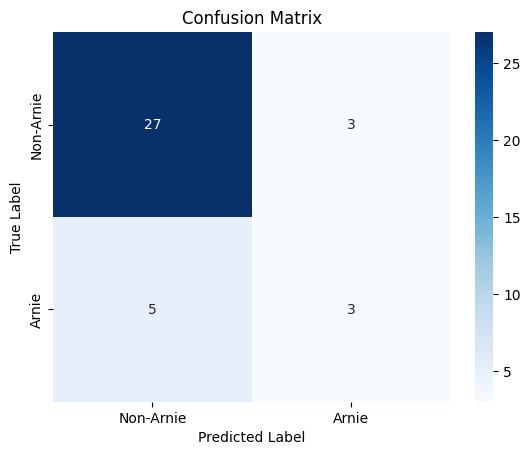

In [10]:
# Plot confusion matrix for visualization
conf_matrix = confusion_matrix(y_test, test_predictions)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Arnie", "Arnie"],
            yticklabels=["Non-Arnie", "Arnie"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()